# Rejection Sampling
Many programming languages have functions that generate random numbers. There are often function that sample randomly from the standard normal distribution $\mathcal N(0,1)$, the standard uniform, $\mathrm{Unif}(0,1)$, etc. But what if we want to sample from a probability distributution that your language doesnt support? We can use rejection sampling. For rejection sampling, we want a distribution, $\mathcal D$ that we know how to sample, such that there exists $m>0$ such that for $Y \sim \mathcal D$,  $mY>X$ and $\mathrm{supp}(X)\subseteq \mathrm{supp}(Y)$. In other words we need a scalar multiple of $Y$ to have a pdf that bounds the pdf of $X$ from above and $\mathrm{supp}(X)\subseteq \mathrm{supp}(Y)$ mean that for a given value $x$, if $f_X(x)$ give a non-zero probability, then $f_Y(x)$ also gives a non-zero probability at the same point $x$.

## The Basics

To run through the idea of rejection sampling, let's look at a specific example. Assume we want to draw random samples from a distribution with the pdf $f_X(x)$ defined as

$
f_X(x) = \begin{cases}
           30(x^2-2x^3+x^4) & \text{if }x\in[0,1]\\
           0                & \text{otherwise}
         \end{cases}.
$

We can plot this pdf as well.

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np

# Defining the pdf
f_X = lambda x: 30*(x**2-2.0*x**3 + x**4) if x>=0 and x<= 1  else 0

# Calculating x and y values
x = np.linspace(-0.1,1.1); y = np.array(map(f_X, x))

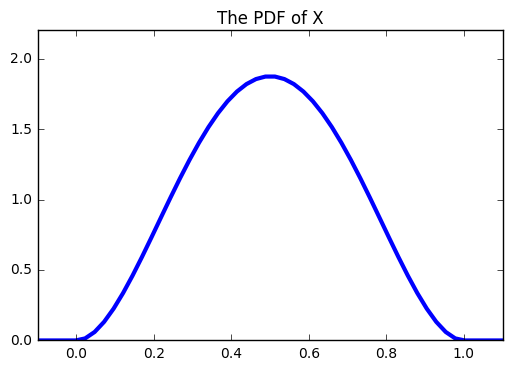

In [2]:
%matplotlib inline

plt.plot(x,y, lw = 3)
plt.xlim(-0.1, 1.1)
plt.ylim(0, 2.2)
plt.title("The PDF of X")

To statisfy the support condition notice that non-zero probabilties are only possible on the interval $[0,1]$, so $\mathrm{supp}(X)=[0,1]$. We can choose $Y$ to come from the standard uniform distribution, $Y\sim\mathrm{Unif(0,1)}$. In this case, $\mathrm{supp}(Y)=[0,1]$, which statisfies the support condition. However, we also need the bound $f_X(x)$ above by a scalar multiple of $f_Y(y)$. From the plot of $f(x)$, we can see that none of the values are larger than 2. Also, the pdf of $Y$ is 1 if $x\in [0,1]$ and 0 otherwise, so we can bound $f_X$ above by $mf_Y(y)$ is ww choose $m=2$. To see this let's plot $f_X(x)$ and $m\cdot f_Y(x)$.

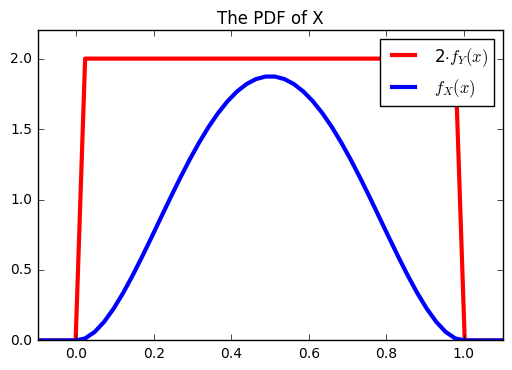

In [3]:
%matplotlib inline
# Define scaled Envelope Distribution
f_Y = lambda y: 1 if y>=0 and y<= 1  else 0

# Define m
m=2

def PlotPDF(plotTitle="The PDF of X"):
    # caclulate y values for mf_X
    y2 = m*np.array(map(f_Y, x))

    # Plot
    plt.plot(x, y2,"red", lw = 3, label="{}$\cdot f_Y(x)$".format(m))
    plt.plot(x, y, lw = 3, label="$f_X(x)$")
    plt.xlim(-0.1, 1.1)
    plt.ylim(0, 2.2)
    plt.title(plotTitle)
    plt.legend()
    
PlotPDF()

Now that we have chosen the distribution that we can sample from $Y\sim \mathrm{Unif}(0,1)$ and the scaling factor $m$, we will draw randomly from the distribution of $Y$ to choose the $x$-value, call it $x_0$. Then to choose a $y$-value, we plug $x_0$ into $f_Y$ and randomly scale it by a value, $u_0$, drawn from $\mathrm{Unif}(0,1)$. We know the ploint will land under $m\cdot f_Y$, so if it also lands under $f_X$, we accept $x_0$ as a random sample. If it lands above $f_X$ we reject it and draw again until we have an accpeted example. To illustrate this let's plot two examples: one reject example and one accpet exampe.

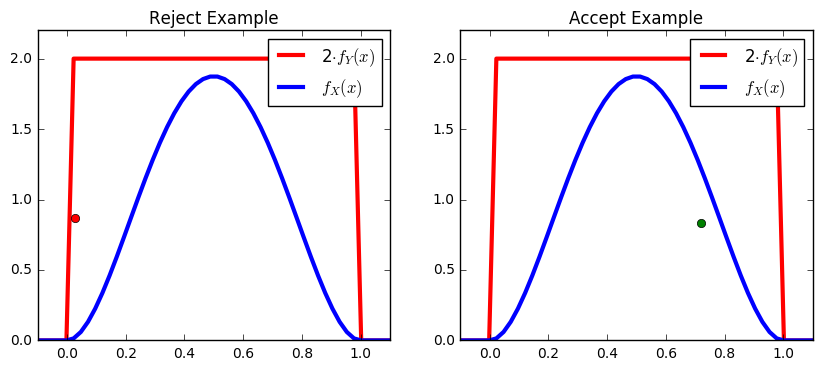

In [4]:
def plotRejectExample():

    np.random.seed(2) # for a consistant example. Don't use in real applications

    # Regenerate Plot of PDFs
    PlotPDF(plotTitle="Reject Example")

    # Draw from Unif(0,1)
    u = np.random.uniform(0,1)

    # Draw from f_Y for an x-value
    x0 = np.random.uniform(0,1)

    # plug x0 into m*f_Y and scale it by u to get a y-values
    y0 = m*f_Y(x0)*u

    plt.plot(x0, y0,"ro")

def plotAcceptExample():
    np.random.seed(1) # for a consistant example. Don't use in real applications

    # Regenerate Plot of PDFs
    PlotPDF(plotTitle="Accept Example")

    # Draw from Unif(0,1)
    u = np.random.uniform(0,1)

    # Draw from f_Y for an x-value
    x1 = np.random.uniform(0,1)

    # plug x0 into m*f_Y and scale it by u to get a y-values
    y1 = m*f_Y(x1)*u

    plt.plot(x1, y1,"go")

    
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plotRejectExample()

plt.subplot(1,2,2)
plotAcceptExample()


From these two examples, we can see that in the "Reject Example" plot the point lands above $f_X$, so we reject it, throw it away and we would have to draw again. In the next plot titled "Accept Example" we see that the point land under $f_X$, so we accept $x_0$ as a randome sample. 

To summarize, the steps to randomly sample $X$ with pdf $f_X$
1. Choose constant $m>0$ and random variable $Y$ such that $\mathrm{supp}(Y)\subseteq \mathrm{supp}(X)$ and for any $x$, we have $\;f_X(x)\leq m\cdot f_Y(x)$.

2. Randomly draw $x_0$ from the distribution of $Y$. 

3. Randomly draw $u$ from $\mathrm{Unif}(0,1)$.

4. Set $y_0 = u\cdot m\cdot f_Y(x_0)$.

5. If $y_0 \leq f_X(x_0)$, then accept $x_0$ as a random sample of $X$. Otherwise, discard and return to step 2.

In [5]:
def drawSamples(Xpdf, m, Ydist, nSamples):
    samples = np.array([]) # will store both rejected and accepted samples
    nAccepted = 0          # Counts Accepted 
    while nAccepted < nSamples:
        x0 = Ydist.rvs()
        u = np.random.uniform(0,1)
        y0 = u*m*Ydist.pdf(x0)
        
        # If we have an accepted example
        if y0 <= Xpdf(x0):
            samples = np.append(samples, np.array([x0,y0,1]))
            nAccepted += 1
        else:
            samples = np.append(samples, np.array([x0,y0,0]))
    return samples.reshape(samples.shape[0]/3,3)

Now let's check how good the samples are by drawing 5000 and plotting them.

Number of Iterations: 9940
    Number of accepted samples: 5000
    Number of rejected samples: 4940
    Proportion of rejected samples: 0.50
    


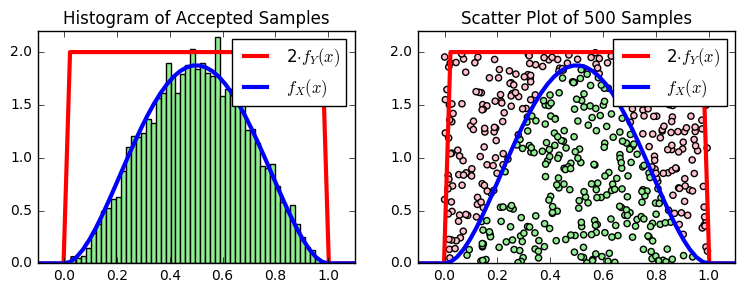

In [6]:
%matplotlib inline

def runSimulation(Xpdf, m, Ydist):
    # set plot size
    plt.figure(figsize=[9,3])

    # Draw 5000 Samples
    X = drawSamples(Xpdf, m=m, Ydist=Ydist, nSamples=5000)

    # Plot Histogram
    plt.subplot(1,2,1)
    AcceptedX = X[X[:,2]==1]
    plt.hist(AcceptedX[:,0], normed=True, bins=50, color="lightgreen")
    PlotPDF("Histogram of Accepted Samples")

    # Plotting a Scatter plot with both rejected and accepted samples
    plt.subplot(1,2,2)
    colDict = {0:"pink",1:"lightgreen"}
    pointColor = map(colDict.get,X[:,2])
    plt.scatter(X[0:500,0],X[0:500,1], c=pointColor)
    plt.xlim(0,1)
    plt.ylim(0,2)
    PlotPDF("Scatter Plot of 500 Samples")

    # Printing details of the process
    print("""Number of Iterations: {:.0f}
    Number of accepted samples: {:.0f}
    Number of rejected samples: {:.0f}
    Proportion of rejected samples: {:0.2f}
    """.format(X[:,2].shape[0], sum(X[:,2]), sum(1-X[:,2]), sum(1-X[:,2])/X[:,2].shape[0] ))
    
runSimulation(f_X, m=2, Ydist=ss.uniform(0,1))

## Optimizing the value of $m$
So we see from the histogram of the left that we do have a decent sampling of $X$ since the histogram follows the curve of the pdf $f_X(x)$. With the scatter plot on the right, we can see the rejected samples in pink and the accepted samples in light green. This plot shows us how many wasted samples were drawn. In fact, about half of the samples we drew ended up being rejected. If we were able to choose a better bounding function, $m\cdot f_Y(x)$, we could get the same number of accepted samples with fewer iterations. 

For this example, we could improve the algorithm by choosing a better value for $m$. Recall, we chose $m$ by looking at the plot and choosing an upper bound of 2, however if we choose $m$ to be the maximum of $f_X$, we would have essentially never chosen all of the candidate samples between $y=2$ and $y=\max_x f_X(x)$, thus decreasing the number of iterations we had to go through. 

So lets find the max of $f_X(x)$. We can do this by finding the place where the derivative is zero. 

$\begin{align*}
\frac{df_X}{dx} 
      &= \begin{cases}
           \frac{d}{dx}30(x^2-2x^3+x^4) & \text{if }x\in[0,1]\\
           \frac{d}{dx}0                            & \text{otherwise}
         \end{cases} \\
      &= \begin{cases}
           30(2x-6x^2+4x^3) & \text{if }x\in[0,1]\\
           0                            & \text{otherwise}
         \end{cases}
\end{align*}$

We can tell by the graph that the max does not occur out side of the interval $[0,1]$, so let's just look at $30(2x-6x^2+4x^3)$. If we set it to zero we get the following:

$\begin{align*}
  0 &= 30(2x-6x^2+4x^3) &&\text{divide by 30}\\
  0 &= 2x-6x^2+4x^3     &&\text{factor}\\
  0 &= x(2-6x+4x^2)     &&\\
  0 &= x(1-2x)(2-2x)     &&\\
  &x=0\;\text{ or }\;1-2x=0\;\text{ or }\;2-2x=0
\end{align*}$

This implies that he optimal values are at $x=0, x=1/2$ or $x=1$. Plugging these into $f_X$ shows that $x=1/2$ is the optimal value, which we could have guessed from just looking at the plot. So this means we want to set $m$ to be the maximum value, $m = f_X(1/2)\approx 1.875$. Lets create the same two plots of the histogram and scatter plot as we did before, but with the new values of $m=1.875$.


Number of Iterations: 9307
    Number of accepted samples: 5000
    Number of rejected samples: 4307
    Proportion of rejected samples: 0.46
    


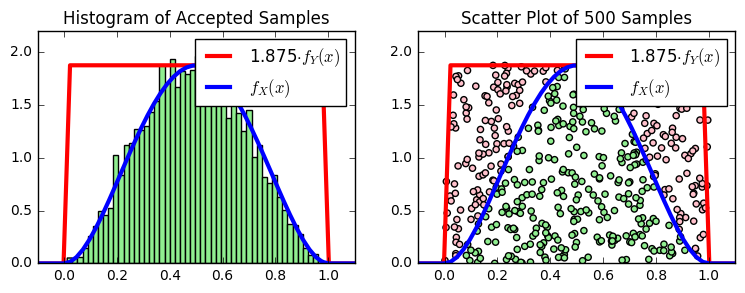

In [7]:
# New value of m.
m = f_X(0.5)

runSimulation(f_X, m=m, Ydist=ss.uniform(0,1))

Now we see that there are indeed fewer iterations than the previous examples using $m=2$. 

## Choice of Distribution of $Y$
So far we only looked at the uniform distribution for $Y$, but we can choose any distribution that satisfies the support and boudning conditions. If you notice this curve looks like a normal curve with out the long tails. So why don't we choose $f_Y$ to be pdf of a normal curve. We already know that the maximum of $f_X$ is at $x=1/2$ and we also know that the max of a normal curve is at the mean, so we need to choose the mean of $Y$ to be $1/2$. Now after playing with the values of $\sigma$ and $m$, I decided to go with $m=1.2$ and $\sigma = 0.25$, which gives:

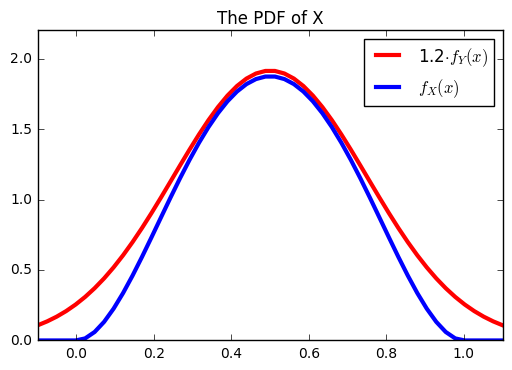

In [8]:
# Set dstribution of Y
Y_Dist = ss.norm(0.5,0.25)

# Set pdf for Y
f_Y = lambda y: Y_Dist.pdf(y)

# Define m
m=1.2

def PlotPDF(plotTitle="The PDF of X"):
    # caclulate y values for mf_X
    y2 = m*np.array(map(f_Y, x))

    # Plot
    plt.plot(x, y2,"red", lw = 3, label="{}$\cdot f_Y(x)$".format(m))
    plt.plot(x, y, lw = 3, label="$f_X(x)$")
    plt.xlim(-0.1, 1.1)
    plt.ylim(0, 2.2)
    plt.title(plotTitle)
    plt.legend()
    
PlotPDF()

Let's plot the histogram and scatter plot for this new $Y$.

Number of Iterations: 5955
    Number of accepted samples: 5000
    Number of rejected samples: 955
    Proportion of rejected samples: 0.16
    


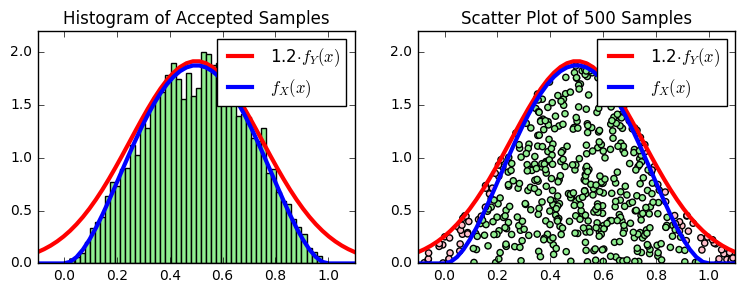

In [9]:
%matplotlib inline
runSimulation(f_X, m=m, Ydist=Y_Dist)

This is a huge improvement. Now we are only throwing away about 1 out of every 6 candidates instead of 1 out of every 2 like the example with the uniform distribution. 